In [1]:
import os
import torch
import cv2
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

ORIGINAL_DATA_PATH = Path('/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class SpaceNetDataset(Dataset):
    def __init__(self, root_dir, split='train', split_ratios=(0.7, 0.2, 0.1), seed=42, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        
        # --- 1. Gather All Paths ---
        classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        
        raw_samples = []
        rng = random.Random(seed)
        
        print(" Gathering file paths...")
        for cls_name in classes:
            cls_dir = self.root_dir / cls_name
            # Get all potential image files
            all_images = sorted([
                f for f in cls_dir.glob('*') 
                if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tif']
            ])
            rng.shuffle(all_images)
            
            # Apply Splits
            n = len(all_images)
            n_train = int(n * split_ratios[0])
            n_test = int(n * split_ratios[1])
            
            if split == 'train': selected = all_images[:n_train]
            elif split == 'test': selected = all_images[n_train:n_train + n_test]
            else: selected = all_images[n_train + n_test:]
                
            for img_path in selected:
                raw_samples.append((str(img_path), self.class_to_idx[cls_name]))

        # --- 2. YOUR LOGIC: Try All -> Retry Queue ---
        self.samples = self._run_two_pass_validation(raw_samples)
        
        print(f" Final Dataset Ready: {len(self.samples)} valid images.")

    def _run_two_pass_validation(self, raw_samples):
        """
        Implements the logic: 
        1. Try All 
        2. Add failures to Queue 
        3. Retry Queue
        """
        valid_samples = []
        retry_queue = []
        
        print(f" Phase 1: Validating {len(raw_samples)} images (First Pass)...")
        
        # --- PASS 1: Try All ---
        for sample in tqdm(raw_samples, desc="Checking Data"):
            img_path, label = sample
            if self._is_image_valid(img_path):
                valid_samples.append(sample)
            else:
                # FAILED? Push to Queue
                retry_queue.append(sample)
        
        # --- PASS 2: Process Retry Queue ---
        if len(retry_queue) > 0:
            print(f"Found {len(retry_queue)} failed images. Retrying Queue...")
            
            for sample in tqdm(retry_queue, desc="Retrying Queue"):
                img_path, label = sample
                # Try one last time
                if self._is_image_valid(img_path):
                    print(f"Recovered: {Path(img_path).name}")
                    valid_samples.append(sample)
                else:
                    print(f"Permanently Removed: {Path(img_path).name}")
                    # We do NOT add it to valid_samples, so it is deleted.
        else:
            print(" Perfect Dataset! No failures in Pass 1.")
            
        return valid_samples

    def _is_image_valid(self, path):
        """Helper to check if image opens without error."""
        try:
            # Quick check with OpenCV (Fastest)
            img = cv2.imread(path)
            if img is None:
                return False
            return True
        except:
            return False

    def __getitem__(self, idx):
        # Now __getitem__ is simple because we KNOW the data is valid!
        img_path, label = self.samples[idx]
        
        # Use our robust loader (OpenCV + Alpha Composite)
        # We don't need retry logic here anymore.
        cv_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        # Standardize Formats
        if cv_img.shape[2] == 4:
            img = cv2.cvtColor(cv_img, cv2.COLOR_BGRA2RGBA)
            pil_img = Image.fromarray(img)
            background = Image.new("RGBA", pil_img.size, (0, 0, 0))
            image_final = Image.alpha_composite(background, pil_img).convert("RGB")
        elif cv_img.shape[2] == 3:
             image_final = Image.fromarray(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))
        else:
             image_final = Image.fromarray(cv2.cvtColor(cv_img, cv2.COLOR_GRAY2RGB))
            
        if self.transform:
            image_final = self.transform(image_final)
            
        return image_final, label

    def __len__(self):
        return len(self.samples)

 Gathering file paths...
 Phase 1: Validating 8974 images (First Pass)...


Checking Data: 100%|██████████| 8974/8974 [15:39<00:00,  9.56it/s]


Found 961 failed images. Retrying Queue...


Retrying Queue:   6%|▌         | 53/961 [00:00<00:01, 523.53it/s]

Permanently Removed: galaxy_page_9_image_3_0_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_12_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_4_2_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_5_0_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_13_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_6_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_1_0_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_9_0_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_1_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_13_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_4_1_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_9_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_10_0_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_11_1_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_3_1_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_5_aug2_SwinIR_large.pn

Retrying Queue:  17%|█▋        | 161/961 [00:00<00:01, 514.33it/s]

Permanently Removed: galaxy_page_25_image_2_4_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_20_3_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_8_0_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_12_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_2_3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_5_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_13_2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_18_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_7_0_SwinIR_large.png
Permanently Removed: planet_page_15_image_3_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_7_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_3_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_11_3_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_9_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_2_1_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_9

Retrying Queue:  28%|██▊       | 269/961 [00:00<00:01, 527.78it/s]

Permanently Removed: galaxy_page_8_image_6_0_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_3_3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_15_4_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_12_3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_3_0_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_1_4_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_3_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_12_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_13_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_11_0_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_4_4_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_2_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_2_1_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_19_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_9_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_20_2_SwinIR_

Retrying Queue:  39%|███▊      | 372/961 [00:00<00:01, 476.44it/s]

Permanently Removed: galaxy_page_7_image_2_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_14_0_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_5_4_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_17_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_7_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_4_1_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_9_1_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_19_2_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_11_3_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_12_0_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_15_3_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_8_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_13_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_12_1_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_3_3_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_7_0_SwinIR_large.png

Retrying Queue:  49%|████▉     | 472/961 [00:00<00:01, 479.61it/s]

Permanently Removed: galaxy_page_2_image_6_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_17_4_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_14_2_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_4_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_8_0_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_6_1_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_1_0_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_19_1_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_9_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_7_2_SwinIR_large.png
Permanently Removed: planet_page_4_image_13_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_1_4_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_15_0_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_1_2_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_17_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_3_2_SwinIR

Retrying Queue:  59%|█████▉    | 569/961 [00:01<00:00, 471.37it/s]

Permanently Removed: galaxy_page_5_image_1_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_13_2_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_14_1_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_13_3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_1_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_3_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_3_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_5_3_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_10_0_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_6_4_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_16_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_18_2_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_4_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_16_3_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_12_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_12_SwinI

Retrying Queue:  70%|███████   | 676/961 [00:01<00:00, 498.87it/s]

Permanently Removed: galaxy_page_8_image_12_2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_20_1_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_18_4_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_8_1_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_15_4_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_6_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_8_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_15_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_2_2_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_2_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_18_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_6_3_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_7_3_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_17_0_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_6_2_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_14_aug3_SwinIR_large.

Retrying Queue:  82%|████████▏ | 786/961 [00:01<00:00, 524.13it/s]

Permanently Removed: galaxy_page_5_image_12_3_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_1_2_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_19_4_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_20_2_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_14_4_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_14_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_16_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_20_0_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_12_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_1_2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_3_4_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_14_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_8_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_20_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_2_4_SwinIR_large.png
Permanently Removed: planet_page_15_image_3_2

Retrying Queue:  95%|█████████▌| 916/961 [00:01<00:00, 590.79it/s]

Permanently Removed: galaxy_page_5_image_18_1_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_16_0_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_10_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_8_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_8_3_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_18_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_17_1_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_8_4_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_20_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_20_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_11_3_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_16_4_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_9_3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_1_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_15_SwinIR_large.png
Permanently Removed: galaxy_page_25_image_3_4_SwinIR_large.png
Perm

Retrying Queue: 100%|██████████| 961/961 [00:01<00:00, 525.41it/s]


Permanently Removed: galaxy_page_7_image_11_4_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_20_4_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_2_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_6_4_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_12_1_SwinIR_large.png
Permanently Removed: galaxy_page_6_image_18_0_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_20_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_4_0_SwinIR_large.png
 Final Dataset Ready: 8013 valid images.
 Gathering file paths...
 Phase 1: Validating 2561 images (First Pass)...


Checking Data: 100%|██████████| 2561/2561 [04:26<00:00,  9.60it/s]


Found 269 failed images. Retrying Queue...


Retrying Queue: 100%|██████████| 269/269 [00:00<00:00, 1797.95it/s]

Permanently Removed: galaxy_page_25_image_5_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_5_4_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_12_0_SwinIR_large.png
Permanently Removed: planet_page_15_image_3_1_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_5_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_7_image_14_4_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_12_3_SwinIR_large.png
Permanently Removed: galaxy_page_4_image_9_aug3_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_1_SwinIR_large.png
Permanently Removed: galaxy_page_9_image_11_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_3_image_4_3_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_14_4_SwinIR_large.png
Permanently Removed: galaxy_page_2_image_6_2_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_7_aug2_SwinIR_large.png
Permanently Removed: galaxy_page_5_image_5_1_SwinIR_large.png
Permanently Removed: galaxy_page_8_image_10_4_SwinIR_la

Batch Shape: torch.Size([32, 3, 224, 224])


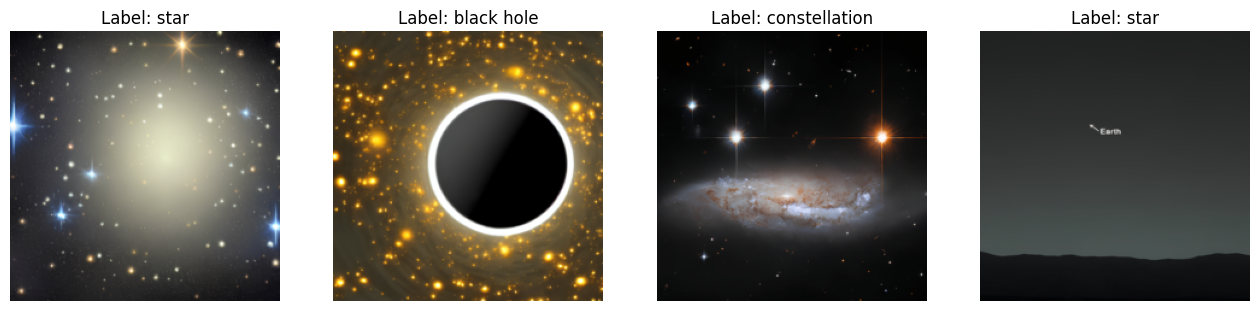

In [3]:
# 1. Define Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SpaceNetDataset(ORIGINAL_DATA_PATH, split='train', transform=data_transforms)
test_dataset = SpaceNetDataset(ORIGINAL_DATA_PATH, split='test', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 4. Visualization Loop
def show_batch(dataloader, class_names):
    try:
        images, labels = next(iter(dataloader))
        print(f"Batch Shape: {images.shape}")
        
        plt.figure(figsize=(16, 6))
        for i in range(min(4, len(images))): # Show up to 4 images
            ax = plt.subplot(1, 4, i + 1)
            
            # Un-normalize
            img = images[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Visualization Error: {e}")

# Run Visualization
class_names = list(train_dataset.class_to_idx.keys())
show_batch(train_loader, class_names)

In [4]:
# --- FINAL CELL: Verification & Summary ---

print("📊 Dataset Summary")
print("-" * 30)
print(f"Training Set: {len(train_dataset)} images")
print(f"Testing Set:  {len(test_dataset)} images")
print("-" * 30)

# Verify Test Loader works too (Crucial for evaluation)
try:
    test_images, test_labels = next(iter(test_loader))
    print(f"✅ Test Loader works! Batch shape: {test_images.shape}")
    
    # Optional: Check Class Distribution in a batch
    unique, counts = np.unique(test_labels.numpy(), return_counts=True)
    print(f"Random Test Batch Class Distribution: {dict(zip(unique, counts))}")
    
except Exception as e:
    print(f"❌ Test Loader Failed: {e}")

print("\n🚀 Ready for Model Training!")

📊 Dataset Summary
------------------------------
Training Set: 8013 images
Testing Set:  2292 images
------------------------------
✅ Test Loader works! Batch shape: torch.Size([32, 3, 224, 224])
Random Test Batch Class Distribution: {np.int64(0): np.int64(32)}

🚀 Ready for Model Training!
